# COGS 108 - Final Project : An Insight on the Correlation of Social Media Impressions and Box Office Performance

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [ X ] NO - keep private

# Overview

In this project we explore if several tweet factors indicate a likelihood of a higher box offices for the top 100 movies of 2021. We explore our data by graphing the box offices of our selection of movies, finding the frequency distribution of words in select movies and measuring sentiment for each tweet in our dataset. We move on to create linear regression models with scatterplots to measure correlations between tweet count and boxoffices as well as tweet sentiment and box offices. We find that our data supports our hypthothesis and that their is a corelation between the aforementioned variables.

# Names

  - Fajar Dirham
  - Robbie Kovar
  - Erik Cisneros
  - Julie Ngan
  - Mohamed Abdilahi


<a id='research_question'></a>
# Research Question

How do the amount of positive and negative tweets affect how well American movies do in the box office?

<a id='background'></a>

## Background & Prior Work

Trying to quantify how social media affects the real world is not a new idea. The specific question we are trying to ask, relating social media impressions and box office success for movies, has been explored by other parties in the past. A thesis paper from the University of Miami school of communication found positive correlation coefficients between engagements in Instagram, Facebook, and Twitter and box office numbers[^dejesus]. In the paper, engagements were calculated by accounting for the followers of posts. The author took movies from Rotten Tomatoes, used Box Office Mojo for revenue data, and used Rival IQ (a social media platform analytics service). These positive correlation coefficients suggest that there "exists a moderate or strong positive correlation between engagement rates and box office for limited release films".

Another similar study by Neuralink and Facebook hoping to uncover the impact social media has on a movie’s success, particularly box office sales, found that Facebook ads contributed a significant portion to a movie’s marketing (20%) despite only accounting for a small percentage of its expenditure (4%).[^meta] In other words, the budget spent on Facebook ads ended up having a larger impact than its cost would entail. In the study they acknowledge how social media has become a competitive platform for media consumption, likening it to how television was revolutionary in marketing back in its heyday. Similarly, our group acknowledges how social media has become an influential and impactful communication platform, replacing traditional methods of self-expression such as word of mouth with the publishing of public posts. As such we hope to uncover if the brief mention of movie titles in people’s posts, has the potential to drive up sales for movies.

References (include links):
- 1) De Jesus, Kimberly. “Social Media Engagement and Film Box Office.” University of Miami School of Communication, 2020. [^meta]: “New: Study Unveils Secrets to Box Office Marketing.” Meta for Business, https://www.facebook.com/business/m/verticals/entertainment-media/social-media-impact-on-movie-attendance.
- 2)

# Hypothesis


We believe that the more social media impressions a movie has before coming out results in it doing better in the box office in its opening weekend, regardless of if the impressions are positive or negative.

# Dataset(s)

Dataset 1

    Dataset Name: Movie Report
    Link to the dataset: https://www.the-numbers.com/movies/report/All/All/All/All/All/All/United-States/All/All/None/None/2021/2021/None/None/None/None/None/None?show-release-date=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On&view-order-by=domestic-box-office&view-order-direction=desc
    Number of observations: 100

This dataset is the list of the top 100 American movies domestically, internationally, and worldwide. We will use this dataset to help us answer our research question on whether the amount of tweets is correlated to how well it does commercially.
DataSet 2

    Dataset Name: Tweets
    Link to the dataset: N/A, webscraped
    Number of observations: 801929

This dataset is scraped from Twitter, using a 3rd party scraping tool, snscrape. Using the titles found in the Movie Report dataset, we will fetch the number of tweets that reference these titles, and list them with a tweet for each row. This dataset has a column marked 'movie_id' which corresponds to which movie the tweet is from and its index in the Movie Report datset. We will only fetch tweets the day of a movie's release up to 2 months after as hype for a movie usually peaks around when it is released and slowly dies down.


# Setup

### Read MovieReport.csv into a dataframe

In [43]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [106]:
import pandas as pd
data = pd.read_csv('MovieReport.csv')
data.head()

,Released,Title,Domestic\r\nBox Office,International\r\nBox Office,Worldwide\r\nBox Office
1,"Dec 17, 2021",Spider-Man: No Way Home,"$804,617,772","$1,083,808,579","$1,888,426,351"
2,"Sep 3, 2021",Shang-Chi and the Legend of the Ten R…,"$224,543,292","$207,700,000","$432,243,292"
3,"Oct 1, 2021",Venom: Let There be Carnage,"$213,550,366","$288,050,013","$501,600,379"
4,"Jul 9, 2021",Black Widow,"$183,651,655","$196,100,000","$379,751,655"
5,"Jun 25, 2021",F9: The Fast Saga,"$173,005,945","$548,072,000","$721,077,945"


### Dataset 2 webscrape

In [45]:
# installation of webscraper
#!pip install -q snscrape==0.3.4

Code below takes in a movie title and returns movie titles for snscrape to query twitter with

In [46]:
def format_title(title):
  title = title.lower()

  #handle special cases
  if("f9" in title):
    return ["F9", "fast 9", "fast and furious 9", "f9 the fast saga"]
  if("shang-chi" in title):
    return ["shang chi", "shang chi and the legend of the ten rings"]
  if("summer of soul" in title):
    return ["summer of soul", "summer of soul or when the revolution cannot be televised"]
  if("roadrunner" in title):
    return ['Roadrunner', 'roadrunner anthony bourdain', 'road runner a film about anthony bourdain']
  if("christmas with the chosen" in title):
    return ["Christmas with the chosen", 'christmas with the chosen the messengers']
  if("quiet place" in title):
    return ["a quiet place", "a quiet place part 2", "a quiet place part II"]

  to_return = []
  
  #handle dashes
  title = title.replace("-", " ")

  # handle colons
  colon_split = title.split(':')
  if(len(colon_split) > 1):
    to_return.append(colon_split[0])
    to_return.append(" ".join(colon_split).replace("  ", " "))
  else:
    to_return.append(title)
  

  return to_return


Here we iterate through list of movies to run the appropriate queries. A typical query is ran by snscrape with the words: "{movie title} movie". We are looking for tweets made in the first two months of a movie's release.

READ BELOW BEFORE RUNNING:
1. Results will be outputted to a folder that has to exist and is titles "raw_tweets"
2. It takes hours for the queries to finish
3. The code below only works if the "data" dataframe, which currently only has the contents of MovieReports.csv, has been cleaned. See the next section for how to do this.

In [47]:
import datetime

def scrape_tweets():
    for index,row in data.iterrows():
        title = row['Title']
        words = title.split()
        
        # Skip over movie titles with only 1 word since that will return too many tweets
        if(len(words) == 1):
            continue

        since = row['Released'].strftime('%Y-%m-%d')
        until = (row['Released'] + datetime.timedelta(days=61)).strftime('%Y-%m-%d')
        filename = str(index) + '-' + title.lower().replace(' ', '')
        filename = filename.replace("(","")
        filename += '.txt'


        titles = format_title(title)
        for formatted_title in titles:
            command = 'snscrape --jsonl --since ' + since + ' twitter-search "' + formatted_title + ' movie until:' + until + '" >> raw_tweets/' + filename
            os.system('echo ' + filename)
            os.system(command)

#scrape_tweets()

# Data Cleaning

### Movie Report Cleaning

In [48]:
# Helper Functions

# Function for getting the total number of tweets for a movie title
# from_date - datetime object to start search
# to_date - datetime object to stop search
# title - string title of movie
# returns int number of tweets for the movie 
def num_tweets(from_date, to_date, title):
    start = str(from_date).replace(' 00:00:00', '')
    end = str(to_date).replace(' 00:00:00', '')

    os.system(f"snscrape --since {start} twitter-search '{title} until:{end}' > result-tweets.txt")
    if os.stat("result-tweets.txt").st_size == 0:
       counter = 0
    else:
       df = pd.read_csv('result-tweets.txt', names=['link'])
       counter = df.size
    os.remove('result-tweets.txt')
    print('Number Of Tweets : '+ str(counter))
    return counter

# Function for getting the total number of tweets for a movie title
# from_date - datetime object to start search
# to_date - datetime object to stop search
# title - string title of movie
# N - int number of posts to fetch
# returns list of first N tweets about the movie title 
def get_N_posts(from_date, to_date, title, N):
  posts_list = []
  start = str(from_date).replace(' 00:00:00', '')
  end = str(to_date).replace(' 00:00:00', '')
  os.system("snscrape --format '{content!r}'"+ f" --max-results {N} --since {start} twitter-search '{title} until:{end}' > tweets.txt")
  if os.stat("tweets.txt").st_size == 0:
    os.remove('tweets.txt')
    return posts_list
  else:
    df = pd.read_csv('tweets.txt', names=['content'])
    for row in df['content'].iteritems():
      posts_list.append(row)
    os.remove('tweets.txt')
    return posts_list

# Function for converting date strings into pandas datatime objects
# start - string datetime to start search
# end - string datetime to stop search
# title - string title of movie
# returns int number of tweets for the movie
def standardize_date(str): 
  try:
    str = str.strip()

    str = str.replace('Jan ', "01/")
    str = str.replace('Feb ', "02/")
    str = str.replace('Mar ', "03/")
    str = str.replace('Apr ', "04/")
    str = str.replace('May ', "05/")
    str = str.replace('Jun ', "06/")
    str = str.replace('Jul ', "07/")
    str = str.replace('Aug ', "08/")
    str = str.replace('Sep ', "09/")
    str = str.replace('Oct ', "10/")
    str = str.replace('Nov ', "11/")
    str = str.replace('Dec ', "12/")

    str = str.replace(', ', "/")

    str = str.replace('/1/', "/01/")
    str = str.replace('/2/', "/02/")
    str = str.replace('/3/', "/03/")
    str = str.replace('/4/', "/04/")
    str = str.replace('/5/', "/05/")
    str = str.replace('/6/', "/06/")
    str = str.replace('/7/', "/07/")
    str = str.replace('/8/', "/08/")
    str = str.replace('/9/', "/09/")

    out = str
  except:
    out = "n/a" 

  return out

In [107]:
 #simple renaming of columns so it can be easier to read
data = data.rename(columns={"Domestic\r\nBox Office":"Domestic Box Office", "International\r\nBox Office":"International Box Office", 
            "Worldwide\r\nBox Office":"Worldwide Box Office"})
#data = data.drop(columns=['Unnamed: 0'])

# Transformation of release date string to 'datetime' objects
data['Released'] = data['Released'].apply(standardize_date)
data['Released'] = data['Released'].apply(pd.to_datetime)

# Remove dollar signs and commas from the box office numbers and convert them to floats
data['Domestic Box Office'] = data['Domestic Box Office'].str.replace('$','')
data['Domestic Box Office'] = data['Domestic Box Office'].str.replace(',','').astype(float)
data['International Box Office'] = data['International Box Office'].str.replace('$','')
data['International Box Office'] = data['International Box Office'].str.replace(',','').astype(float)
data['Worldwide Box Office'] = data['Worldwide Box Office'].str.replace('$','')
data['Worldwide Box Office'] = data['Worldwide Box Office'].str.replace(',','').astype(float)
data.sort_values(by='Released', ascending=True)
# Remove null
data.head()

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
1,2021-12-17,Spider-Man: No Way Home,804617772.0,1.083809e+09,1.888426e+09
2,2021-09-03,Shang-Chi and the Legend of the Ten R…,224543292.0,2.077000e+08,4.322433e+08
3,2021-10-01,Venom: Let There be Carnage,213550366.0,2.880500e+08,5.016004e+08
4,2021-07-09,Black Widow,183651655.0,1.961000e+08,3.797517e+08
5,2021-06-25,F9: The Fast Saga,173005945.0,5.480720e+08,7.210779e+08


### Process and clean Tweets

Here we iterate through all the raw tweet data and pull out the content, placing them in a folder that has to exist and is titled "processed_tweets"

In [50]:
import json

def process_file(filename):
    # Using readlines()
    file1 = open('raw_tweets/' + filename, 'r')
    file2 = open('processed_tweets/' + filename, 'a')
    Lines = file1.readlines()
    
    count = 0
    # Strips the newline character
    file2.write("tweet\n")
    for line in Lines:
        count += 1
        obj = json.loads(line.strip())
        content = obj['content']
        content = content.replace(",", "")
        content = content.replace("\n", "")
        content = content.replace("\r", "")
        file2.write(content + '\n')
    
    file1.close()
    file2.close()

def process_tweets():
    yourpath = './raw_tweets/'
    for root, dirs, files in os.walk(yourpath, topdown=True):
        for name in files:
            process_file(name)

#process_tweets()

We take all those processed tweets and put them all into one dataframe

In [51]:
def generate_csv():
  tweet_dfs = []

  def create_dfs(filename):
    temp_df = pd.read_csv('processed_tweets/' + filename)
    id = int(filename[:filename.index('-')])
    temp_df['movie'] = data.iloc[id - 1]['Title']
    temp_df['movie_id'] = id
    tweet_dfs.append(temp_df)

  yourpath = './processed_tweets/'
  for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
          create_dfs(name)

  tweets_df = pd.concat(tweet_dfs)
  tweets_df.sort_values(by='movie_id', inplace=True)
  tweets_df.reset_index(inplace=True, drop=True)
  tweets_df.drop_duplicates(subset=["tweet"], inplace=True)
  tweets_df.to_csv('tweets.csv.zip', index=False)

# generate_csv()

# we just read in the csv afterwards
tweets_df = pd.read_csv("tweets.csv")
print(tweets_df.shape)
tweets_df.head()

(801929, 3)


,tweet,movie,movie_id
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,1
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,1
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,1
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,1
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,1


Now we clean the tweets, removing hashtags and mentions but keeping punctuation as that may convey information.

In [112]:
# Process the tweets first

def clean_text(text):
# Removes all special characters and numericals leaving the alphabets
    to_return = ''
    for word in text.split():
        if not '@' in word and not 'https:' in word:
            to_return += word + " "

    to_return = to_return.replace("#","")
    return to_return[0:len(to_return)-1]

tweets_df["tweet_clean"] = tweets_df['tweet'].apply(clean_text)
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop,tweet_stem
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !...","[spiderman, save, movi, go, experi, !, !, !]"
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,...","[yes-, good, !, grab, extra, napkin, popcorn, ..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,...","[“, spider, man, trailer, stock, price, ”, …, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed],[obsess]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,...","[look, forward, spider-man, tonight, ., if, an..."


# Data Analysis & Results

## Dataset 1

In [108]:
data

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
1,2021-12-17,Spider-Man: No Way Home,804617772.0,1.083809e+09,1.888426e+09
2,2021-09-03,Shang-Chi and the Legend of the Ten R…,224543292.0,2.077000e+08,4.322433e+08
3,2021-10-01,Venom: Let There be Carnage,213550366.0,2.880500e+08,5.016004e+08
4,2021-07-09,Black Widow,183651655.0,1.961000e+08,3.797517e+08
5,2021-06-25,F9: The Fast Saga,173005945.0,5.480720e+08,7.210779e+08
...,...,...,...,...,...
96,2021-04-23,Together Together,1436324.0,0.000000e+00,1.436324e+06
97,2021-07-23,Joe Bell,1405488.0,3.332760e+05,1.738764e+06
98,2021-01-26,Wrong Turn,1251184.0,2.392576e+06,3.643760e+06
99,2021-11-03,CS Lewis: The Most Reluctant Convert,1205000.0,4.792500e+04,1.252925e+06


### Size
For this dataset we have 100 entries

In [109]:
data.shape

(100, 5)

### Missingness
Searching for any anomalous entries we found that 6 movies had an International Box Office of 0. We believe these movies didn't have an international box office because they only released domestically

In [110]:
domestic_only =  data[data['International Box Office'] == 0]
domestic_only

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
41,2021-12-25,American Underdog: The Kurt Warner Story,26514814.0,0.0,26514814.0
58,2021-12-01,Christmas with the Chosen: The Messen…,13388000.0,0.0,13388000.0
75,2021-04-30,Separation,4509143.0,0.0,4509143.0
80,2021-04-02,The Girl Who Believes In Miracles,3163362.0,0.0,3163362.0
83,2021-06-11,The House Next Door: Meet the Blacks 2,2893660.0,0.0,2893660.0
96,2021-04-23,Together Together,1436324.0,0.0,1436324.0


Since we are using box office as a measure of success for a movie, we will remove the aforementioned entries. Their lack of an international box office, makes it difficult to compare them with other movies at an international scope. Additionally it hinders their worldwide box office making them appear less successful than other movies.

In [111]:
data = data[data['International Box Office'] != 0]

Plotting a histogram for the release date of movies, we see that it is fairly uniformly distributed. There is a slight lack of movies during the first quarter the year

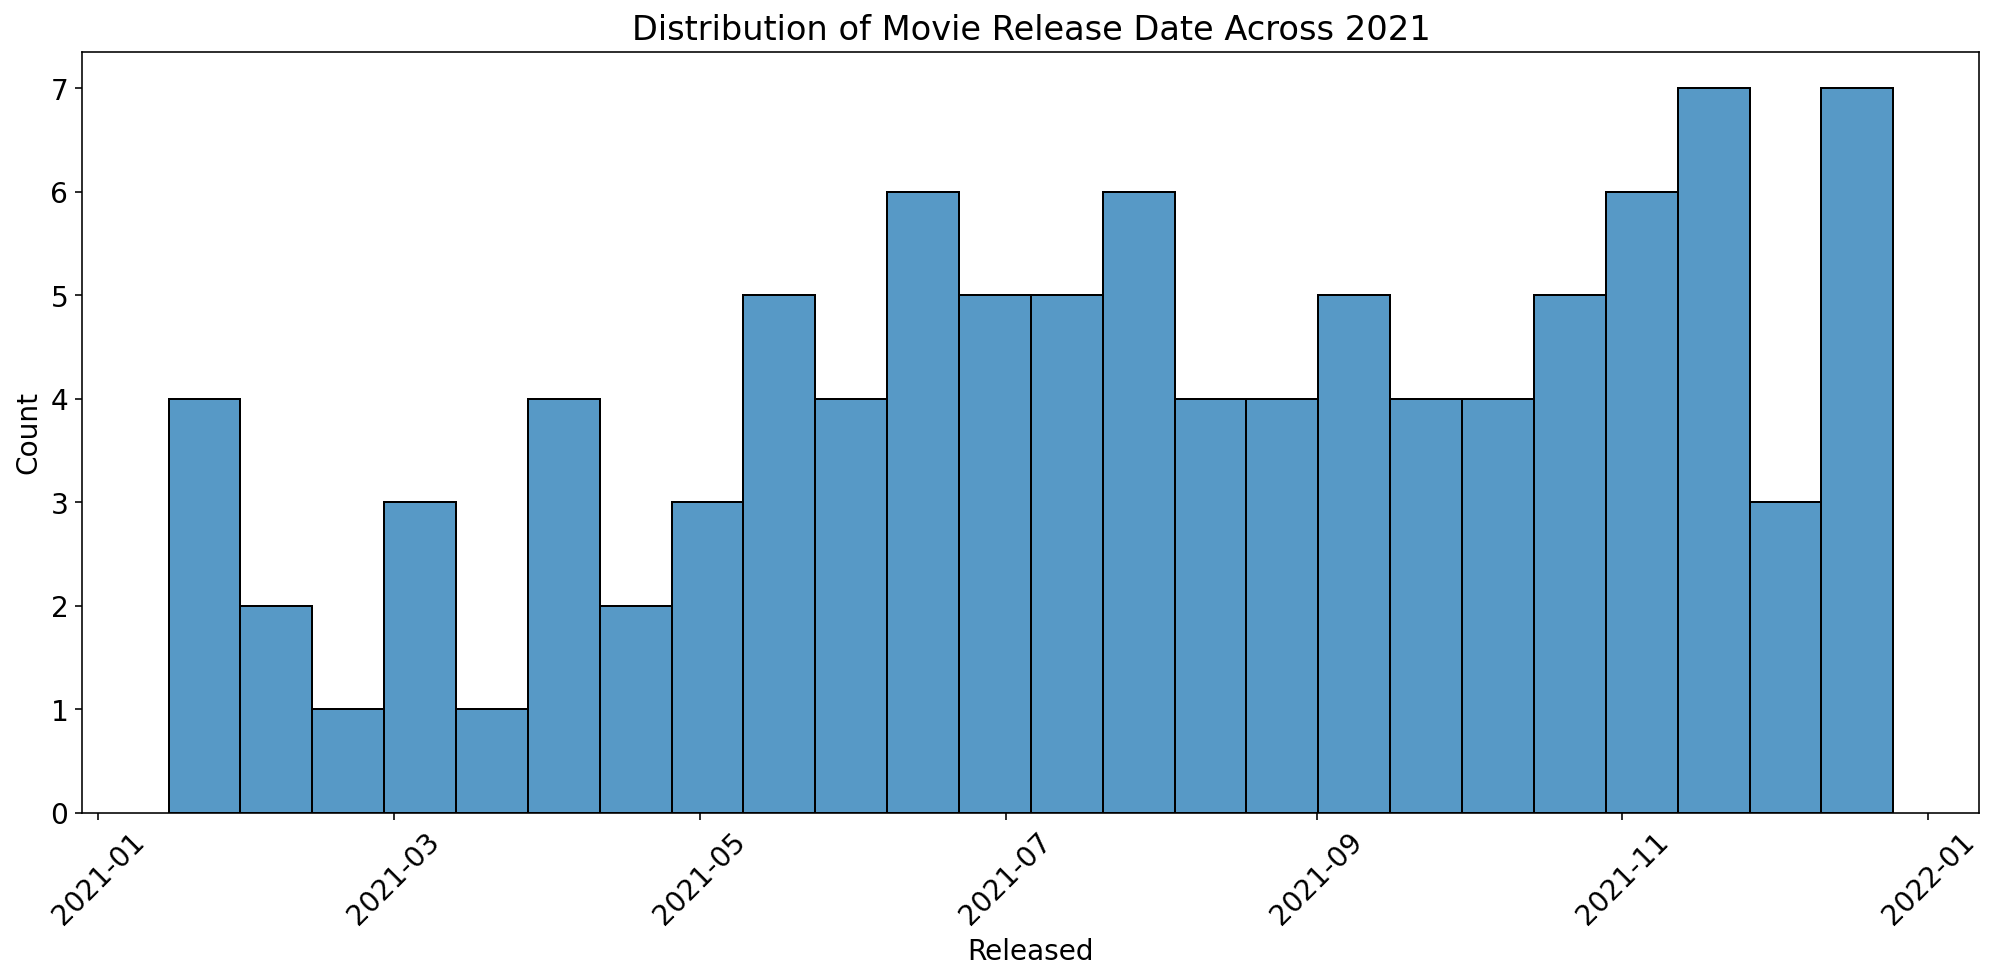

In [94]:
sns.histplot(data, x='Released', bins=24)
plt.title('Distribution of Movie Release Date Across 2021')
plt.xticks(rotation=45)
print()

Plotting for Box Office success, we see all three distributions are highly skewed right. We also spot a few outliers who earned huge box offices.

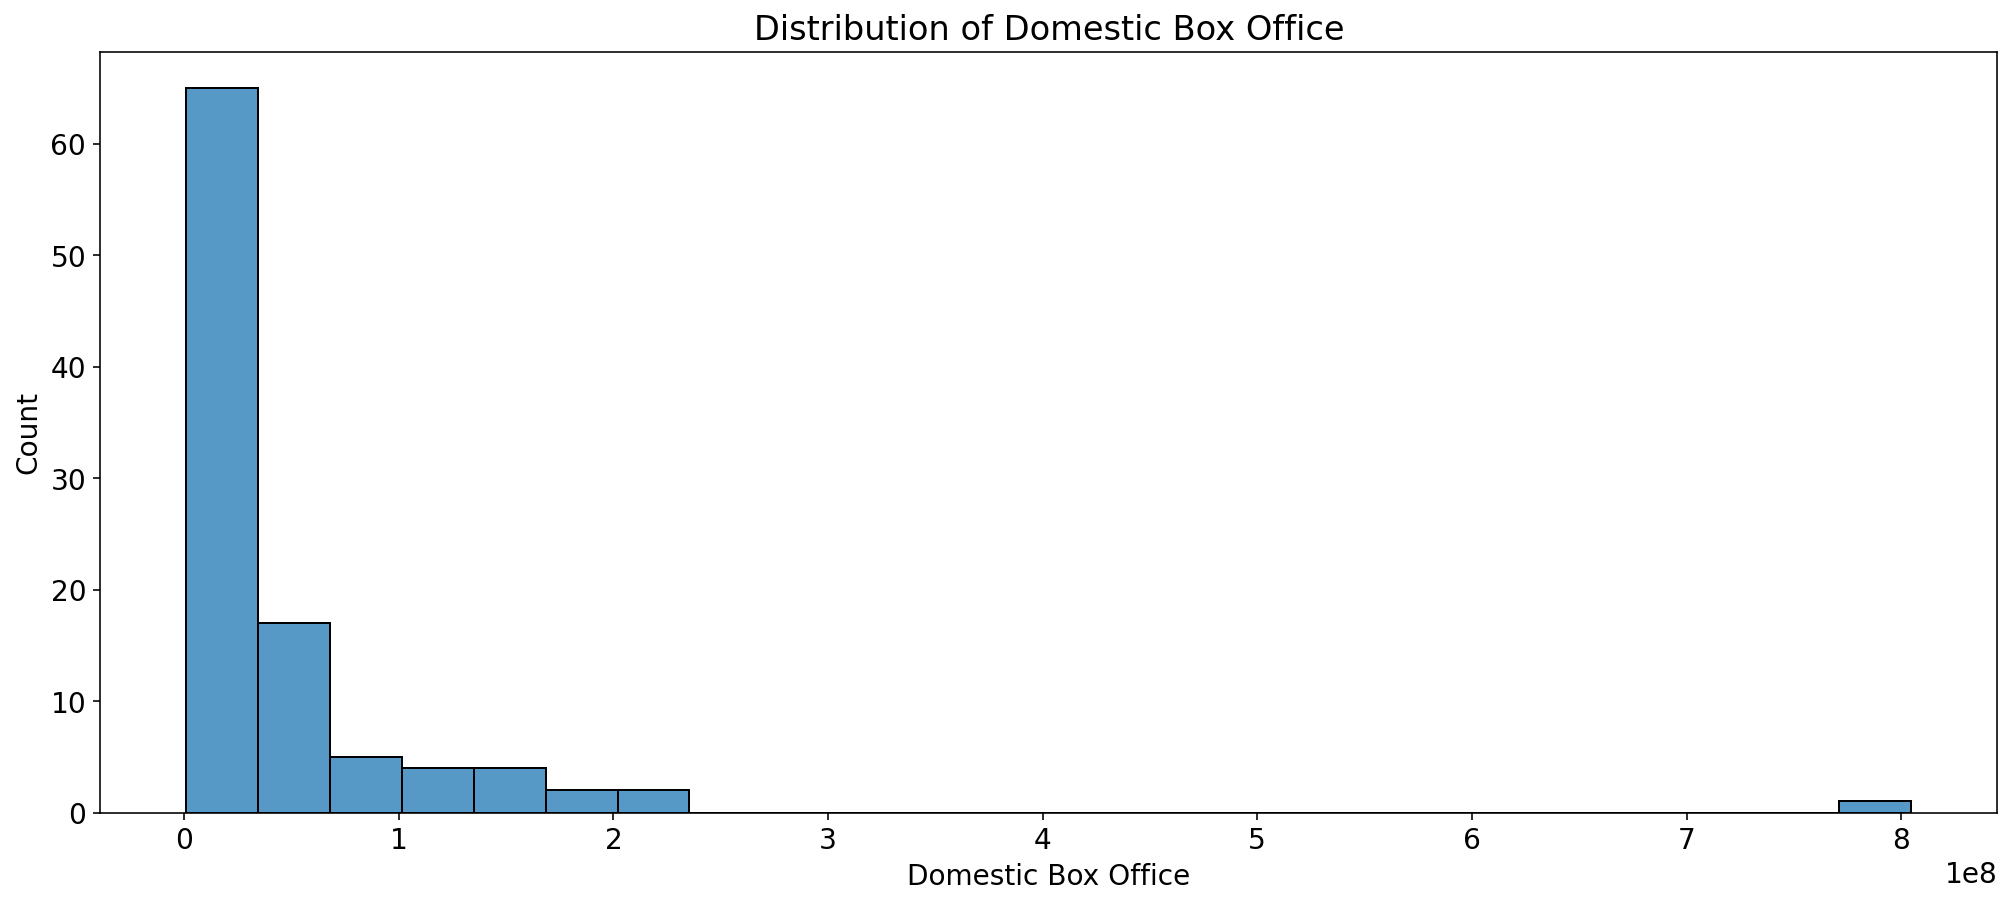

In [95]:
sns.histplot(data, x='Domestic Box Office', bins=24)
plt.title('Distribution of Domestic Box Office')
print()

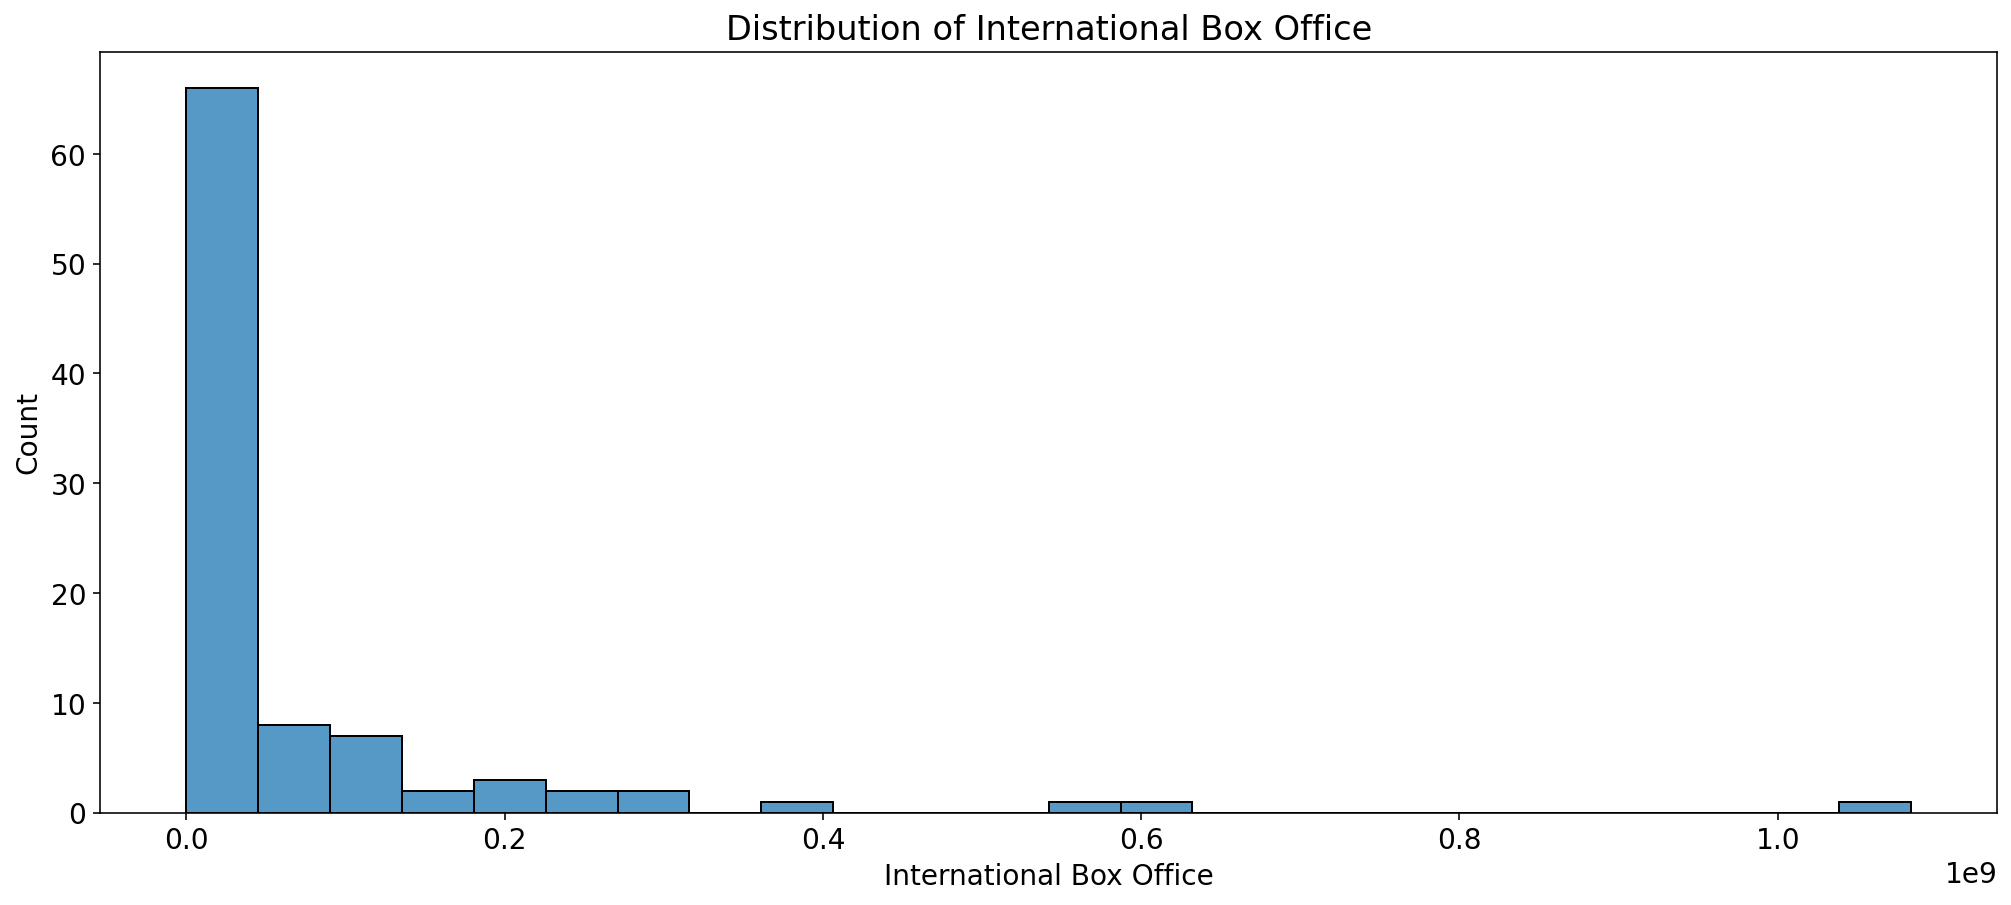

In [60]:
sns.histplot(data, x='International Box Office', bins=24)
plt.title('Distribution of International Box Office')
print()

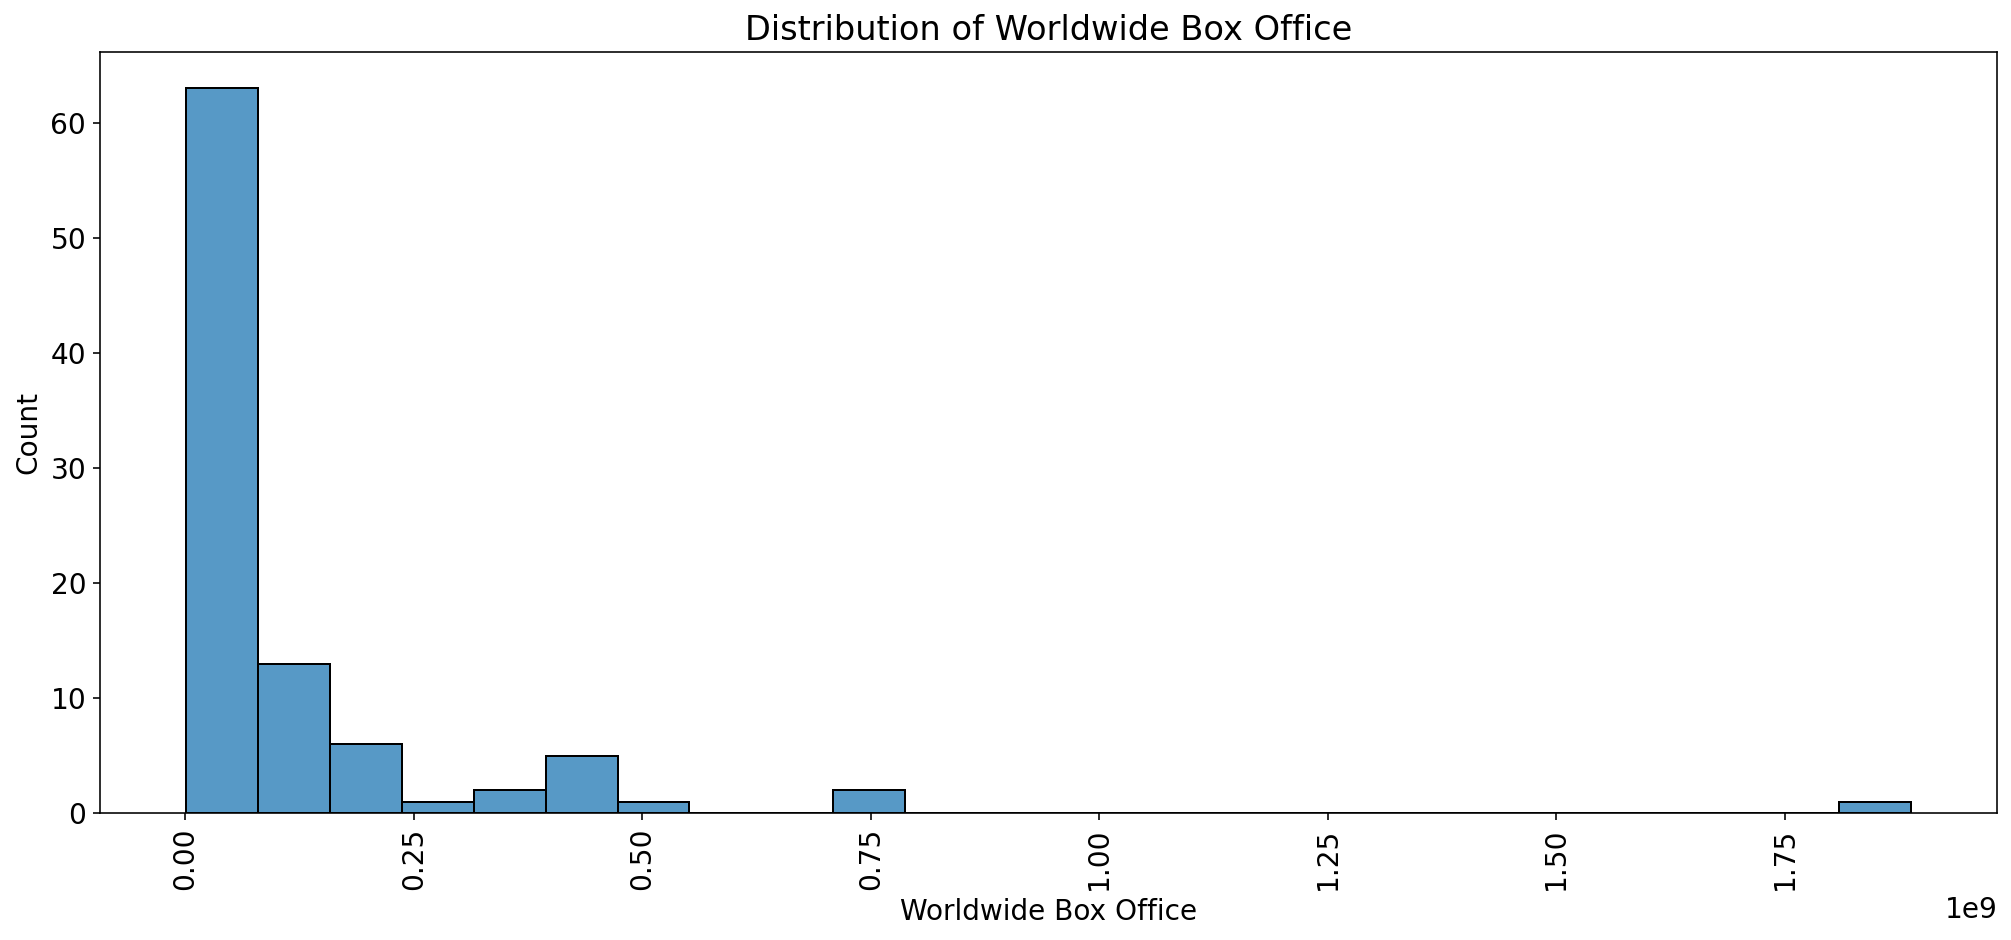

In [61]:
sns.histplot(data, x='Worldwide Box Office', bins=24)
plt.title('Distribution of Worldwide Box Office')
plt.xticks(rotation=90)
print()

### Outliers
We see in both cases that the outlier is "Spider-Man: No Way Home"

In [62]:
data[data['Domestic Box Office'] > (7*(10**8))]

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
94,2021-12-17,Spider-Man: No Way Home,804617772.0,1.083809e+09,1.888426e+09


In [63]:
data[data['Worldwide Box Office'] > (1*(10**9))]

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
94,2021-12-17,Spider-Man: No Way Home,804617772.0,1.083809e+09,1.888426e+09


In [114]:
# rename data for next dataset
movies_df = data
movies_df.columns = ['released', 'movie', 'domestic', 'international', 'worldwide']
movies_df.head()

,released,movie,domestic,international,worldwide
1,2021-12-17,Spider-Man: No Way Home,804617772.0,1.083809e+09,1.888426e+09
2,2021-09-03,Shang-Chi and the Legend of the Ten R…,224543292.0,2.077000e+08,4.322433e+08
3,2021-10-01,Venom: Let There be Carnage,213550366.0,2.880500e+08,5.016004e+08
4,2021-07-09,Black Widow,183651655.0,1.961000e+08,3.797517e+08
5,2021-06-25,F9: The Fast Saga,173005945.0,5.480720e+08,7.210779e+08


## Dataset 2

In [65]:
import pandas as pd
import patsy
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})
import seaborn as sns

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

import warnings
warnings.filterwarnings('ignore')

#import natural language toolkit
import nltk

# download stopwords & punkt & VADER
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fajardirham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fajardirham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fajardirham/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### Simple Exploration

In [66]:
tweets_df

,tweet,movie,movie_id,tweet_clean
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...
...,...,...,...,...
801924,one minute into red rocket and I already know ...,Red Rocket,99,one minute into red rocket and I already know ...
801925,Red Rocket was a wild dirty and cool movie. Si...,Red Rocket,99,Red Rocket was a wild dirty and cool movie. Si...
801926,Honestly surprised Simon Rex is not getting mo...,Red Rocket,99,Honestly surprised Simon Rex is not getting mo...
801927,Red Rocket is a good movie ❤️ https://t.co/TXz...,Red Rocket,99,Red Rocket is a good movie ❤️


Number of tweets per movie

In [67]:
tweets_df.groupby('movie_id').count()

,tweet,movie,tweet_clean
movie_id,,,
0,127734,127734,127734
1,21823,21823,21823
2,56743,56743,56743
3,75414,75414,75414
4,16604,16604,16604
...,...,...,...
95,45131,45131,45131
96,285,285,285
97,2688,2688,2688


As you can see, the data we have scraped only contains 77 movies out of the 100 listed in dataset 1. This is because some movies were too hard to scrape without risking the integrity of the dataset. For example, some movies had 1 word titles which made querying for the movie return too many irrelevant tweets.

### Tokenize

In [68]:
from nltk.tokenize import word_tokenize
tweets_df['tweet_token'] = tweets_df['tweet_clean'].apply(word_tokenize)
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp..."
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]"
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,..."


### Remove stop words

In [69]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tweets_df['tweet_stop'] = tweets_df['tweet_token'].apply(lambda x: [item for item in x if item not in stop_words])
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !..."
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,..."


### Stemming

In [70]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

tweets_df['tweet_stem'] = tweets_df['tweet_stop'].apply(lambda x: [ps.stem(y) for y in x])
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop,tweet_stem
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !...","[spiderman, save, movi, go, experi, !, !, !]"
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,...","[yes-, good, !, grab, extra, napkin, popcorn, ..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,...","[“, spider, man, trailer, stock, price, ”, …, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed],[obsess]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,...","[look, forward, spider-man, tonight, ., if, an..."


### Frequency Distribution of words for F9 and Black Widow

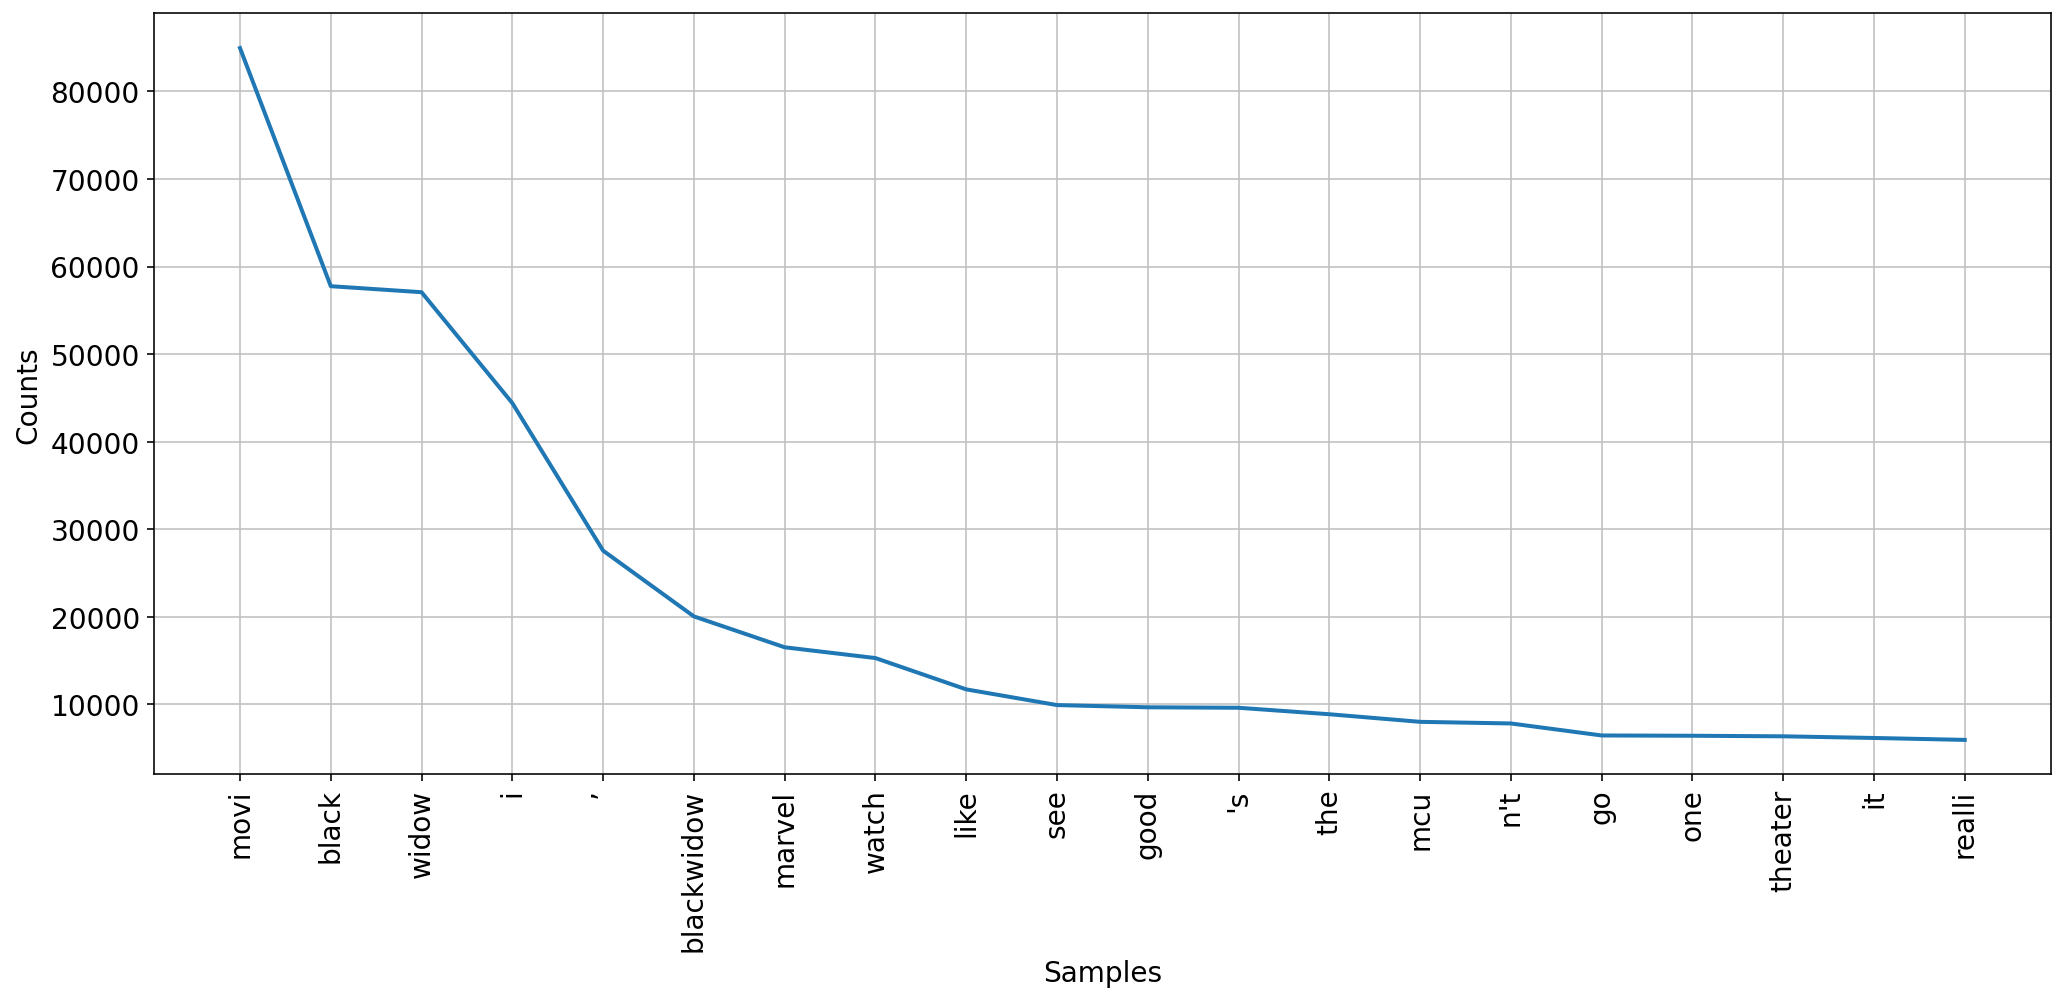

In [71]:
# get words after stemming
bw_tweets = tweets_df[tweets_df['movie'] == 'Black Widow']
tweet_series = bw_tweets.squeeze()
tweet_stem = tweet_series['tweet_stem'].apply(pd.Series).stack()

from nltk.probability import FreqDist
import string

#calculate word frequency
fdist_tweets = FreqDist(tweet_stem)
#delete punctuation counts
for punc in string.punctuation:
    del fdist_tweets[punc]

#get top 20 words
fdist_tweets.plot(20, cumulative=False);

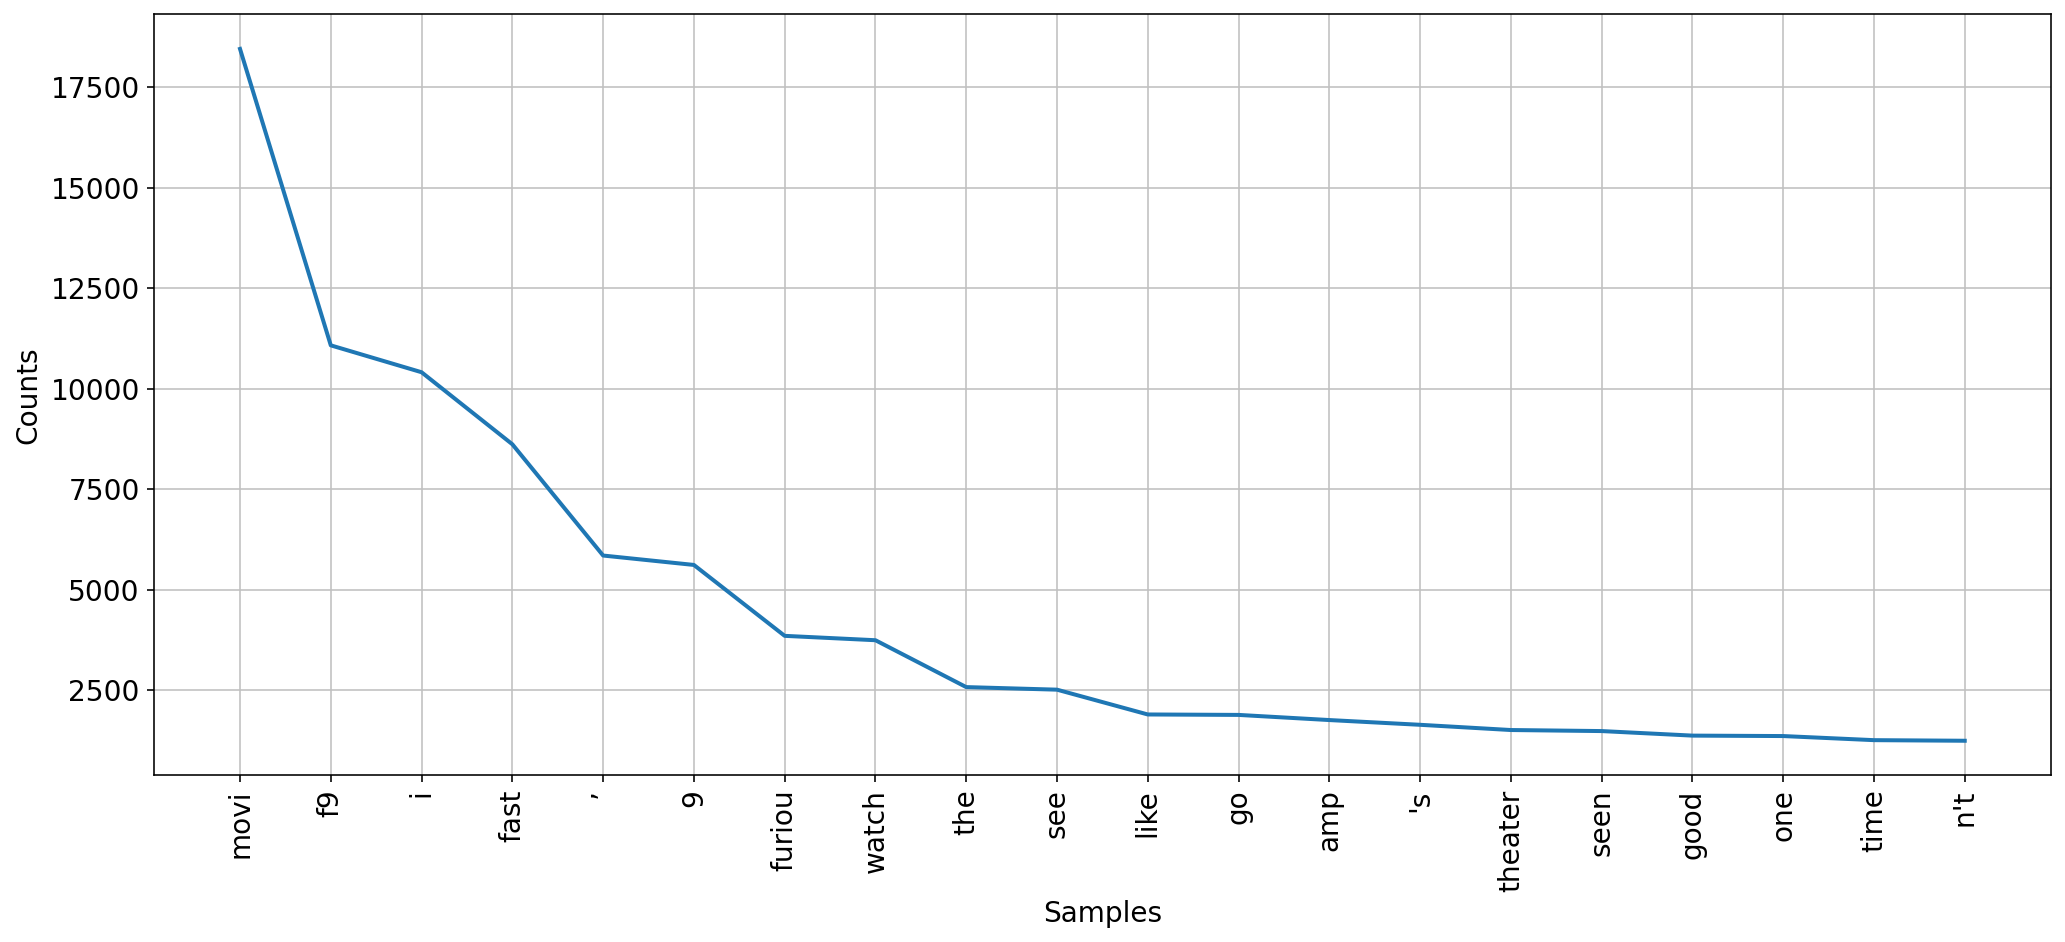

In [73]:
f9_tweets = tweets_df[tweets_df['movie_id'] == 4]
tweet_series = f9_tweets.squeeze()
tweet_stem = tweet_series['tweet_stem'].apply(pd.Series).stack()

from nltk.probability import FreqDist
import string

#calculate word frequency
fdist_tweets = FreqDist(tweet_stem)
#delete punctuation counts
for punc in string.punctuation:
    del fdist_tweets[punc]

#get top 20 words
fdist_tweets.plot(20, cumulative=False);

### VADER sentiment analysis

In [74]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()
test_tweet = tweets_df.iloc[0]['tweet_clean']
print(test_tweet)
print(analyser.polarity_scores(test_tweet))

SpiderMan has saved the movie going experience!!!
{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.5684}


In [120]:
sentiment_df = pd.DataFrame()
sentiment_df['movie_id'] = tweets_df['movie_id']
sentiment_df['tweet_clean'] = tweets_df['tweet_clean']
sentiment_df['sentiment'] = tweets_df['tweet_clean'].apply(analyser.polarity_scores)
sentiment_df.head()

,movie_id,tweet_clean,sentiment
0,1,SpiderMan has saved the movie going experience!!!,"{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou..."
1,1,Yes- so good! Grab extra napkins with your pop...,"{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou..."
2,1,“Spider Man trailer and stock prices”… Story |...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,1,too obsessed,"{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compou..."
4,1,Looking forward to Spider-Man tonight. If anyo...,"{'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compou..."


In [121]:
def spread_sentiment(sentiment_obj, category):
    return sentiment_obj[category]
sentiment_df['compound'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'compound'))
sentiment_df['neg'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'neg'))
sentiment_df['neu'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'neu'))
sentiment_df['pos'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'pos'))
sentiment_df.drop(columns=['sentiment'], inplace=True)
sentiment_df.head()

,movie_id,tweet_clean,compound,neg,neu,pos
0,1,SpiderMan has saved the movie going experience!!!,0.5684,0.00,0.62,0.38
1,1,Yes- so good! Grab extra napkins with your pop...,0.7339,0.00,0.66,0.34
2,1,“Spider Man trailer and stock prices”… Story |...,0.0000,0.00,1.00,0.00
3,1,too obsessed,-0.1779,0.63,0.37,0.00
4,1,Looking forward to Spider-Man tonight. If anyo...,-0.6875,0.25,0.75,0.00


In [122]:
#Group by and mean compound scores
grouped = sentiment_df.groupby(by=['movie_id'])
mean_sentiment_df = grouped.mean()
mean_sentiment_df.head()

,compound,neg,neu,pos
movie_id,,,,
1,0.181999,0.082796,0.749815,0.149046
2,0.397125,0.055206,0.725753,0.219045
3,0.189185,0.064801,0.773404,0.145460
4,0.264739,0.064517,0.769794,0.165674
5,0.032851,0.106320,0.775909,0.117712


In [123]:
# Get number of tweets per movie
count_sentiment_df = grouped.count()
movie_aggregate_df = mean_sentiment_df.merge(count_sentiment_df['tweet_clean'], left_index=True, right_on='movie_id')
movie_aggregate_df.columns = ['compound_mean', 'neg_mean', 'neu_mean', 'pos_mean', 'num_tweets']
movie_aggregate_df.head(10)

,compound_mean,neg_mean,neu_mean,pos_mean,num_tweets
movie_id,,,,,
1,0.181999,0.082796,0.749815,0.149046,127734
2,0.397125,0.055206,0.725753,0.219045,21823
3,0.189185,0.064801,0.773404,0.145460,56743
4,0.264739,0.064517,0.769794,0.165674,75414
5,0.032851,0.106320,0.775909,0.117712,16604
7,0.334896,0.044007,0.768787,0.187207,5910
8,-0.300772,0.225089,0.669063,0.105848,10392
9,0.193592,0.065213,0.803856,0.130930,11077
10,0.310652,0.056961,0.767236,0.170980,25526


In [124]:
# Join with box office
joined_df = movie_aggregate_df.merge(movies_df, left_on='movie_id', right_index=True)
joined_df.head(10)

,compound_mean,neg_mean,neu_mean,pos_mean,num_tweets,released,movie,domestic,international,worldwide
movie_id,,,,,,,,,,
1,0.181999,0.082796,0.749815,0.149046,127734,2021-12-17,Spider-Man: No Way Home,804617772.0,1.083809e+09,1.888426e+09
2,0.397125,0.055206,0.725753,0.219045,21823,2021-09-03,Shang-Chi and the Legend of the Ten R…,224543292.0,2.077000e+08,4.322433e+08
3,0.189185,0.064801,0.773404,0.145460,56743,2021-10-01,Venom: Let There be Carnage,213550366.0,2.880500e+08,5.016004e+08
4,0.264739,0.064517,0.769794,0.165674,75414,2021-07-09,Black Widow,183651655.0,1.961000e+08,3.797517e+08
5,0.032851,0.106320,0.775909,0.117712,16604,2021-06-25,F9: The Fast Saga,173005945.0,5.480720e+08,7.210779e+08
7,0.334896,0.044007,0.768787,0.187207,5910,2021-12-22,Sing 2,162790990.0,2.348064e+08,3.975974e+08
8,-0.300772,0.225089,0.669063,0.105848,10392,2021-10-08,No Time to Die,160891007.0,6.005110e+08,7.614020e+08
9,0.193592,0.065213,0.803856,0.130930,11077,2021-05-28,A Quiet Place: Part II,160215764.0,1.364518e+08,2.966676e+08
10,0.310652,0.056961,0.767236,0.170980,25526,2021-11-19,Ghostbusters: Afterlife,129360575.0,7.526112e+07,2.046217e+08


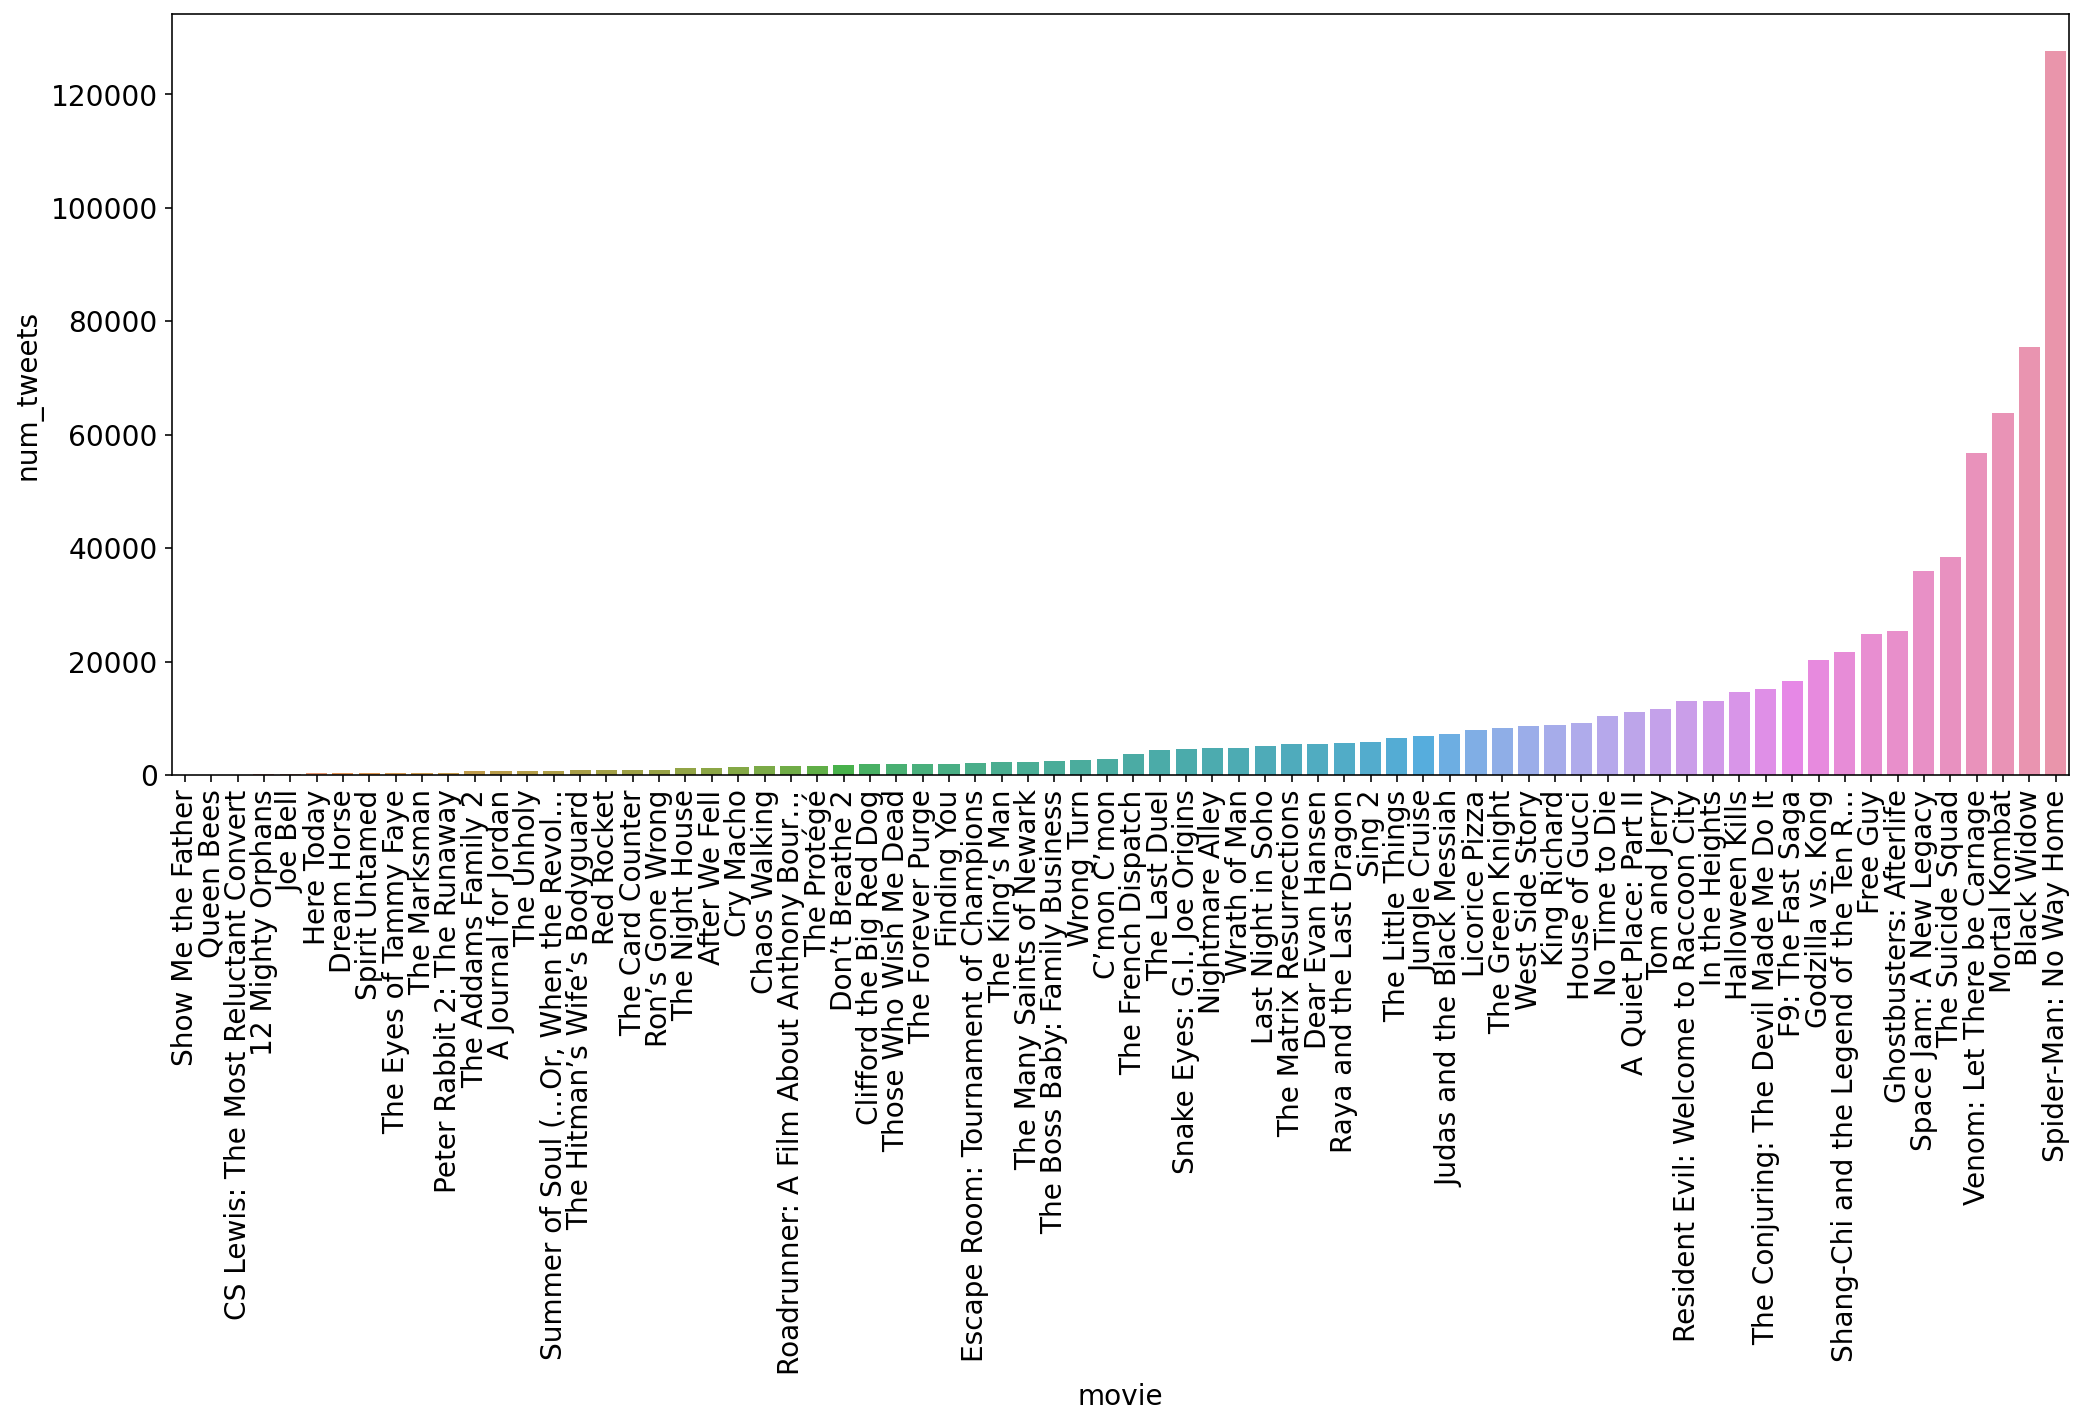

In [125]:
# Plot tweet counts
sorted_count_df = joined_df.sort_values(by='num_tweets', ascending=True)
sorted_count_plot = sns.barplot(data=sorted_count_df, y='num_tweets', x='movie')
for item in sorted_count_plot.get_xticklabels():
    item.set_rotation(90)

In [126]:
# Describe num tweets
joined_df.describe()

,compound_mean,neg_mean,neu_mean,pos_mean,num_tweets,domestic,international,worldwide
count,72.000000,72.000000,72.000000,72.000000,72.000000,7.200000e+01,7.200000e+01,7.200000e+01
mean,0.183922,0.077725,0.776739,0.144381,10490.305556,5.412484e+07,7.958801e+07,1.337129e+08
std,0.187583,0.055489,0.058399,0.037907,20075.412930,1.052776e+08,1.648973e+08,2.638401e+08
min,-0.327764,0.011429,0.606001,0.096179,56.000000,1.039866e+06,2.368600e+04,1.252925e+06
25%,0.135811,0.049149,0.760543,0.119803,981.500000,6.925444e+06,2.467483e+06,1.161355e+07
50%,0.201970,0.060855,0.793768,0.136919,3331.500000,1.751711e+07,2.376443e+07,4.208230e+07
75%,0.293009,0.077408,0.812987,0.153092,9462.000000,5.499663e+07,8.446402e+07,1.446608e+08
max,0.601167,0.245268,0.866928,0.298729,127734.000000,8.046178e+08,1.083809e+09,1.888426e+09


We need to get rid of some outliers and low tweet counts to make our predictions more accurate.

(52, 10)
          compound_mean  neg_mean  neu_mean  pos_mean  num_tweets   released  \
movie_id                                                                       
2              0.397125  0.055206  0.725753  0.219045       21823 2021-09-03   
3              0.189185  0.064801  0.773404  0.145460       56743 2021-10-01   
4              0.264739  0.064517  0.769794  0.165674       75414 2021-07-09   
5              0.032851  0.106320  0.775909  0.117712       16604 2021-06-25   
7              0.334896  0.044007  0.768787  0.187207        5910 2021-12-22   

                                           movie     domestic  international  \
movie_id                                                                       
2         Shang-Chi and the Legend of the Ten R…  224543292.0    207700000.0   
3                    Venom: Let There be Carnage  213550366.0    288050013.0   
4                                    Black Widow  183651655.0    196100000.0   
5                             

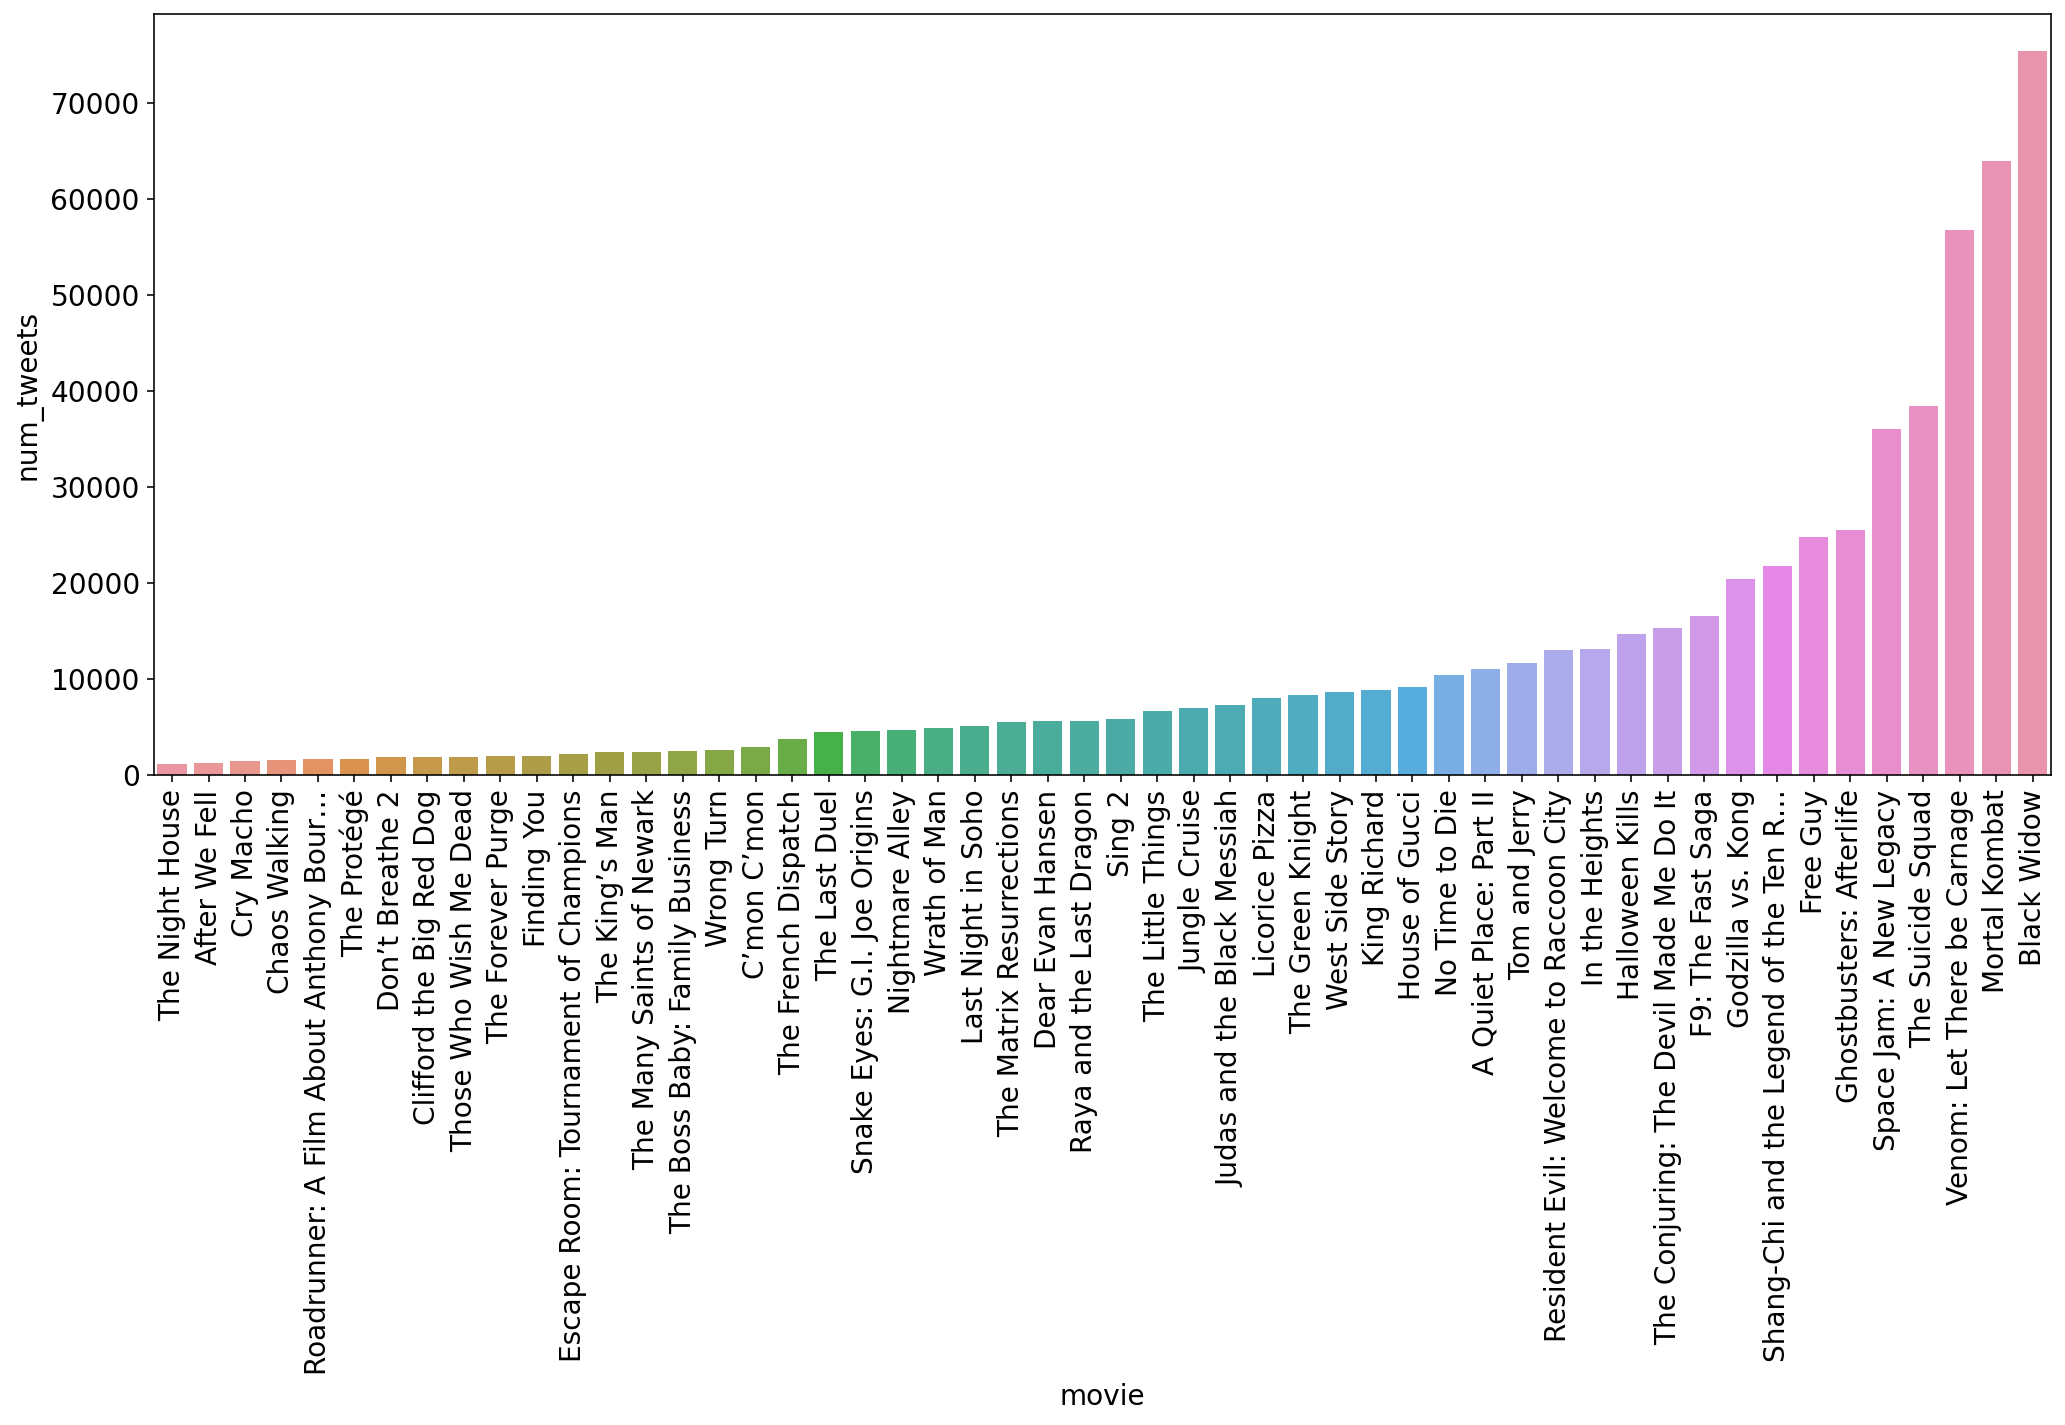

In [127]:
# To remove low count tweets for correlation, we will use movies with 1000 tweets or above
full_joined_df = joined_df
joined_df = joined_df[joined_df['num_tweets'] > 1000]

# Remove spider man
joined_df = joined_df[joined_df['num_tweets'] < 100000]

print(joined_df.shape)
print(joined_df.head())

sorted_count_df = joined_df.sort_values(by='num_tweets', ascending=True)
sorted_count_plot = sns.barplot(data=sorted_count_df, y='num_tweets', x='movie')
for item in sorted_count_plot.get_xticklabels():
    item.set_rotation(90)

### Connections between Average Compound Scores and Domestic Box Office

Let's see if there is a direct connection between average compound scores and domestic box office numbers

In [128]:
correlation_df = pd.DataFrame()
correlation_df['compound'] = joined_df['compound_mean']
correlation_df['domestic'] = joined_df['domestic']
correlation_df.head()

,compound,domestic
movie_id,,
2,0.397125,224543292.0
3,0.189185,213550366.0
4,0.264739,183651655.0
5,0.032851,173005945.0
7,0.334896,162790990.0


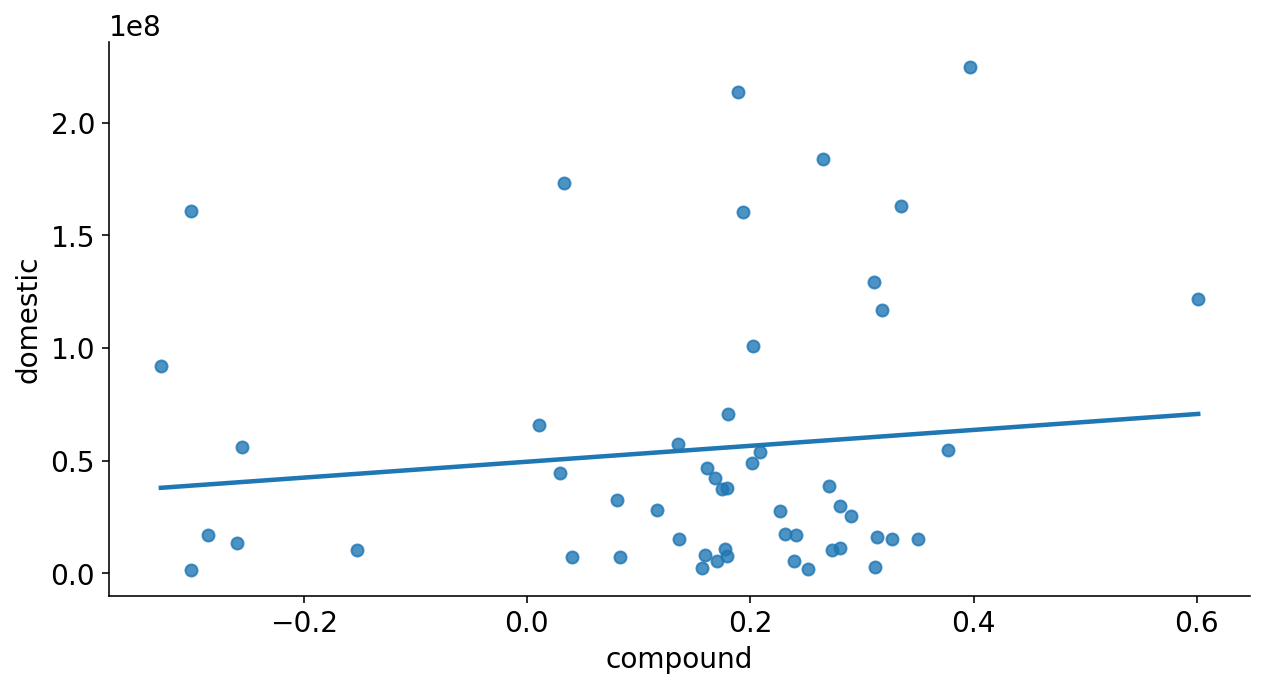

In [129]:
sns.lmplot(x='compound', y='domestic', data=correlation_df, ci=None, aspect=1.8)

In [130]:
outcome, predictors = patsy.dmatrices('domestic ~ compound', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6784
Date:                Tue, 07 Jun 2022   Prob (F-statistic):              0.414
Time:                        00:32:41   Log-Likelihood:                -1004.6
No. Observations:                  52   AIC:                             2013.
Df Residuals:                      50   BIC:                             2017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.949e+07   1.07e+07      4.640      0.0

#### Mini-Conclusion

There does not seem to be a direct correlation between average compound scores of tweets 2 months after release and domestic box office numbers. This is evident from the relatively high p value for our predictor number and low R squared, indicated that the pearson correlation number is low.

### Correlation Between Movie Tweet Count & Domestic Box Office

In [131]:
correlation_df['num_tweets'] = joined_df['num_tweets']
correlation_df.head(10)

,compound,domestic,num_tweets
movie_id,,,
2,0.397125,224543292.0,21823
3,0.189185,213550366.0,56743
4,0.264739,183651655.0,75414
5,0.032851,173005945.0,16604
7,0.334896,162790990.0,5910
8,-0.300772,160891007.0,10392
9,0.193592,160215764.0,11077
10,0.310652,129360575.0,25526
11,0.601167,121626598.0,24851


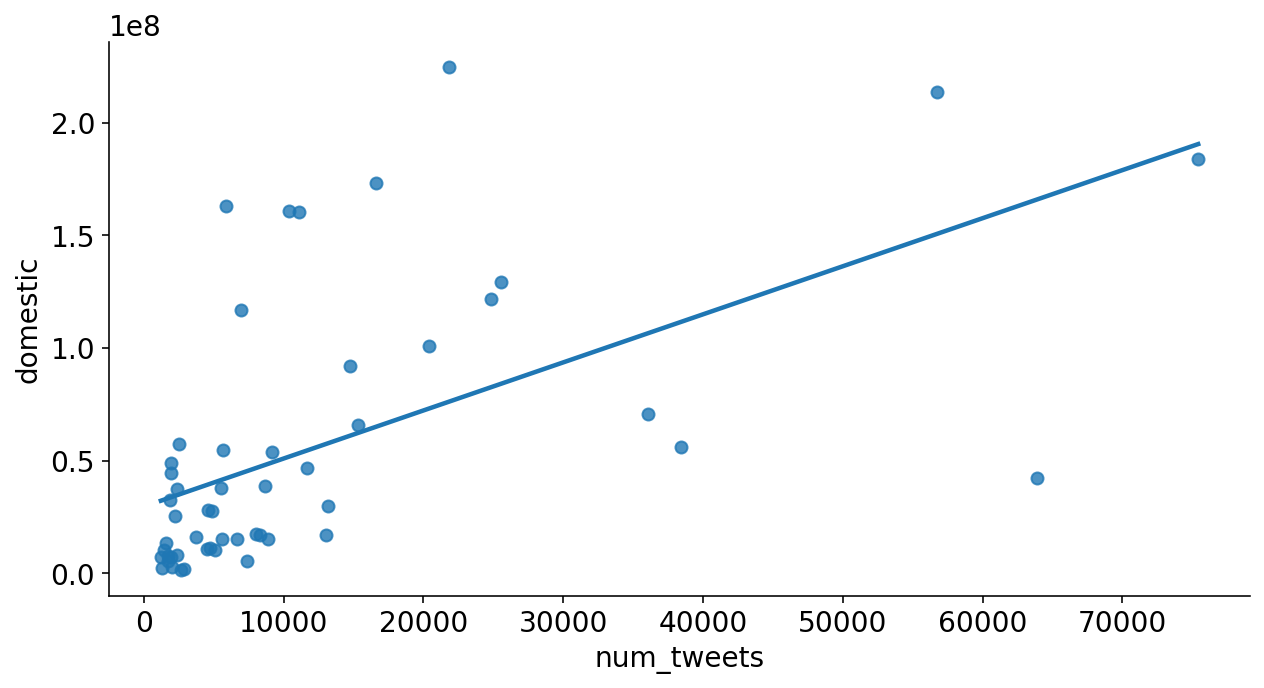

In [132]:
sns.lmplot(x='num_tweets', y='domestic', data=correlation_df,
          ci=None, aspect=1.8)

In [133]:
outcome, predictors = patsy.dmatrices('domestic ~ num_tweets', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     23.02
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           1.49e-05
Time:                        00:32:52   Log-Likelihood:                -995.08
No. Observations:                  52   AIC:                             1994.
Df Residuals:                      50   BIC:                             1998.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.958e+07   8.77e+06      3.374      0.0

#### Mini-Conclusion
There does seem to be a linear relation between the number of tweets and domestic box office numbers. The p value for the predictor is low and the pearson coefficient squared seems to be high enough to suggest a positive correlation. The OLS model suggests that for every tweet, box office numbers would increase by $2133.

Realistically, this makes some sense. Assuming it costs $10 for each movie ticket, $2133 would equal to about 213 people buying tickets for a movie. It is within the realm of possibility that only one out of 213 people would tweet about a movie they have seen.

### Correlation Between Tweet Count of Differing Sentiments & Domestic Box Office 

First we will add labels to our tweets (pos, neg, and neu). Then we will add up the number of labels per movie. Then we will see if there is a correlation between the number of labeled tweets.

In [134]:
def compound_to_label(compound_score):
    if(compound_score >= 0.05): return 'pos'
    if(compound_score <= -0.05): return 'neg'
    return 'neu'

sentiment_df['label'] = sentiment_df['compound'].apply(compound_to_label)
sentiment_df.head(10)

,movie_id,tweet_clean,compound,neg,neu,pos,label
0,1,SpiderMan has saved the movie going experience!!!,0.5684,0.00,0.620,0.380,pos
1,1,Yes- so good! Grab extra napkins with your pop...,0.7339,0.00,0.660,0.340,pos
2,1,“Spider Man trailer and stock prices”… Story |...,0.0000,0.00,1.000,0.000,neu
3,1,too obsessed,-0.1779,0.63,0.370,0.000,neg
4,1,Looking forward to Spider-Man tonight. If anyo...,-0.6875,0.25,0.750,0.000,neg
5,1,because it’s a marvel movie and nwh proved tha...,0.4215,0.00,0.833,0.167,pos
6,1,One of the best spider man movie ✨✨✨,0.6369,0.00,0.625,0.375,pos
7,1,Like you said thanks for giving the movie your...,0.3753,0.05,0.835,0.115,pos
8,1,NWH = a Reboot Origin of all 6 Spideeman movie...,0.4019,0.00,0.920,0.080,pos
9,1,Top 10 movies of 2021: From Spider-Man to Dune...,0.2023,0.00,0.886,0.114,pos


In [135]:
pos_df = sentiment_df[sentiment_df['label'] == 'pos']
neu_df = sentiment_df[sentiment_df['label'] == 'neu']
neg_df = sentiment_df[sentiment_df['label'] == 'neg']


pos_grouped = pos_df.groupby(by=['movie_id'])
pos_count = pos_grouped.count()['tweet_clean']
neu_grouped = neu_df.groupby(by=['movie_id'])
neu_count = neu_grouped.count()['tweet_clean']
neg_grouped = neg_df.groupby(by=['movie_id'])
neg_count = neg_grouped.count()['tweet_clean']
labeled_count_df = pd.DataFrame()
labeled_count_df['pos_count'] = pos_count
labeled_count_df['neu_count'] = neu_count
labeled_count_df['neg_count'] = neg_count
labeled_count_df['num_tweets'] = labeled_count_df['pos_count'] + labeled_count_df['neu_count'] + labeled_count_df['neg_count']

# Remove outliers and low tweet counts
labeled_count_df = labeled_count_df[labeled_count_df['num_tweets'] > 1000]
labeled_count_df = labeled_count_df[labeled_count_df['num_tweets'] < 100000]

# Add domestic
labeled_count_df['domestic'] = correlation_df['domestic']

labeled_count_df.head(10)

,pos_count,neu_count,neg_count,num_tweets,domestic
movie_id,,,,,
2,15628,2727,3468,21823,224543292.0
3,28400,16377,11966,56743,213550366.0
4,45709,12976,16729,75414,183651655.0
5,7042,3303,6259,16604,173005945.0
7,3798,1231,881,5910,162790990.0
8,2576,463,7353,10392,160891007.0
9,5933,2409,2735,11077,160215764.0
10,15976,4602,4948,25526,129360575.0
11,21705,1463,1683,24851,121626598.0


                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     25.45
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           6.37e-06
Time:                        00:34:09   Log-Likelihood:                -994.23
No. Observations:                  52   AIC:                             1992.
Df Residuals:                      50   BIC:                             1996.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.009e+07   8.46e+06      3.555      0.0

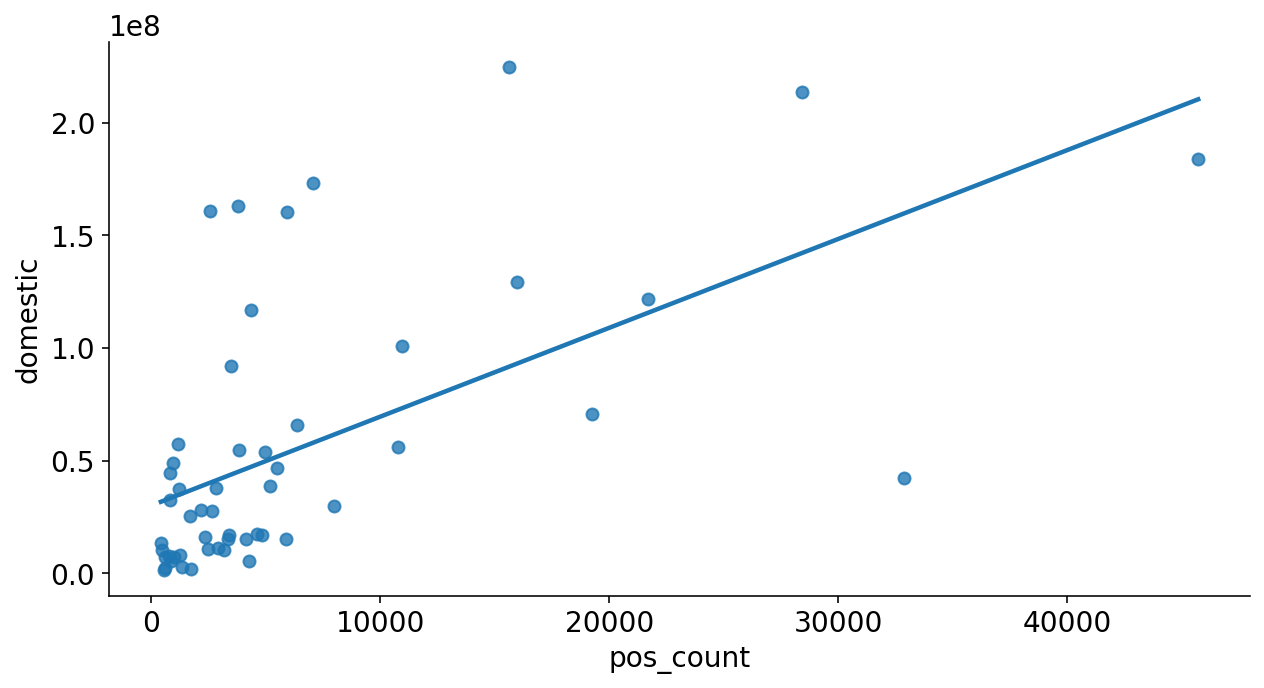

In [136]:
# plot pos
outcome, predictors = patsy.dmatrices('domestic ~ pos_count', labeled_count_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

sns.lmplot(x='pos_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     17.84
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           0.000102
Time:                        00:34:19   Log-Likelihood:                -997.00
No. Observations:                  52   AIC:                             1998.
Df Residuals:                      50   BIC:                             2002.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.544e+07    8.6e+06      4.121      0.0

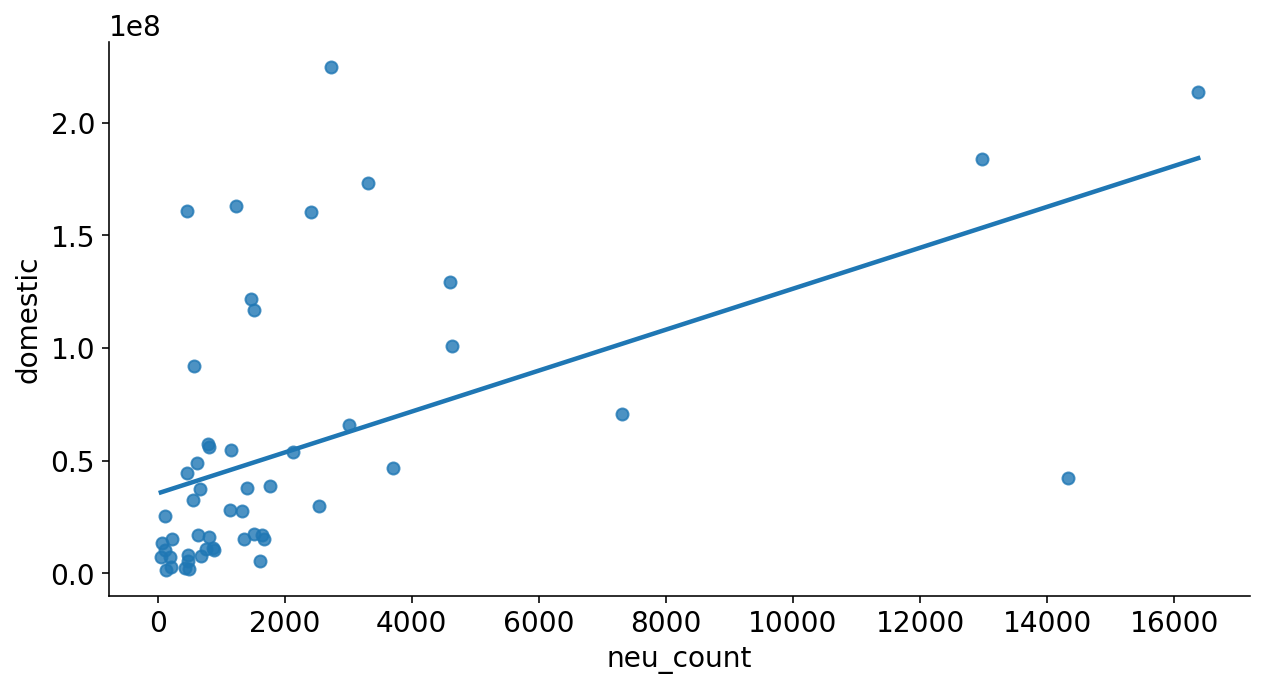

In [137]:
# plot neu
outcome, predictors = patsy.dmatrices('domestic ~ neu_count', labeled_count_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

sns.lmplot(x='neu_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     9.015
Date:                Tue, 07 Jun 2022   Prob (F-statistic):            0.00417
Time:                        00:34:23   Log-Likelihood:                -1000.6
No. Observations:                  52   AIC:                             2005.
Df Residuals:                      50   BIC:                             2009.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.914e+07   9.39e+06      4.168      0.0

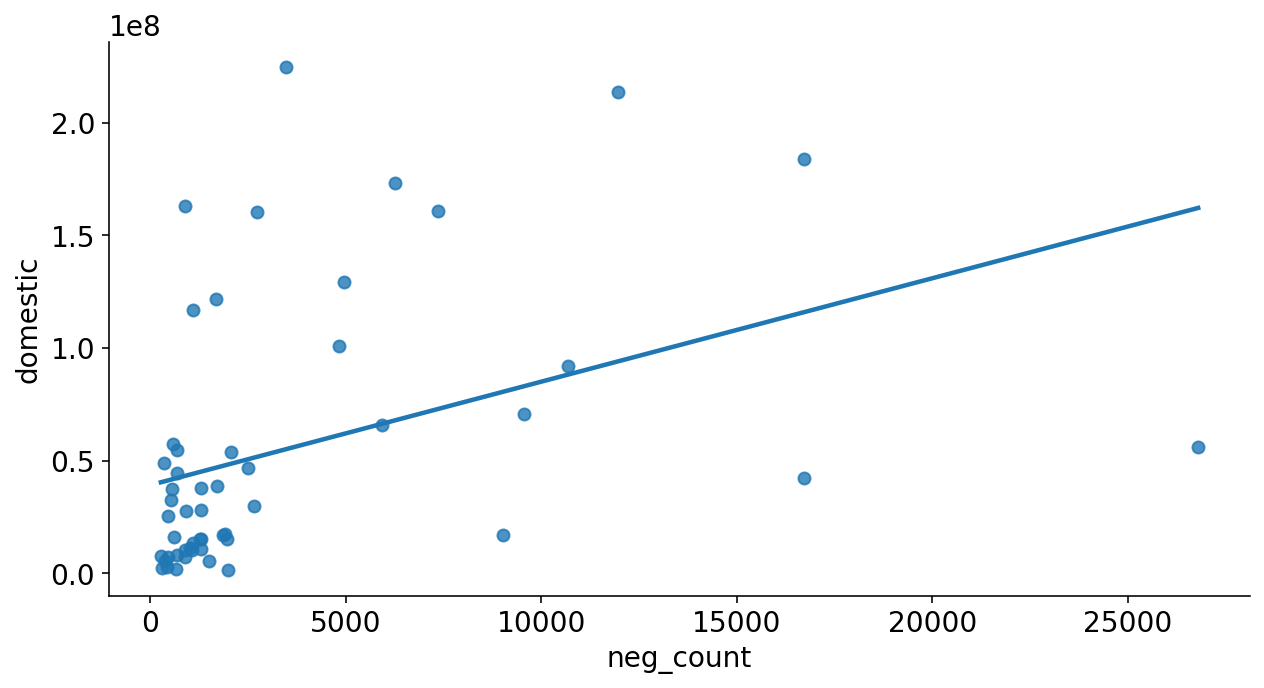

In [138]:
# plot neg
outcome, predictors = patsy.dmatrices('domestic ~ neg_count', labeled_count_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

sns.lmplot(x='neg_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

#### Mini-Conclusion
After observing the graphs and OLS numbers, the sentiments of the tweets do not matter as much. The general trend seems to be that more tweets equate to higher domestic box office numbers, regardless of sentiment. 

### How both compound scores and number of tweets affect domestic box office numbers
We'll be using multivariable OLS to see if compound sentiment scores and number of tweets influence the predictor models in any way.

In [140]:
outcome, predictors = patsy.dmatrices('domestic ~ compound + num_tweets + compound*num_tweets', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     8.181
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           0.000168
Time:                        00:34:41   Log-Likelihood:                -994.19
No. Observations:                  52   AIC:                             1996.
Df Residuals:                      48   BIC:                             2004.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3.286e+07   1

### Mini-Conclusion
The p value of the mean compound score shows that it does not correlate as with the domestic box office numbers. Even trying to see how the mean compound scores and number of tweets both interact with each other to affect domestic box office numbers, only the number of tweets seem to matter the most.

# Ethics & Privacy

Data Collection: The actual act of scraping the data from twitter for our research project is in the clear regarding its eithcality as twitter is a public space. Because we only want the sentiment of the individuals in regards to the movies, their anonymity should be upheld. So, we are planning to only use their tweets and not them as an individual.

Sentiment Analysis: Ideally we would like to not only see if any form of discussion on twitter about a movie increases its performance, we would also like to observe if whether the primary reasoning for performance is based on the the type of discussion being taken place. We would like to divide up the tweets into three; positive, negative or neutral sentiment. While there is a concern for ethics when using sentiment analysis, we believe that the context that we are using it in does not break any moral standards and we are transparent in our goal.

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*